In [65]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
import seaborn as sns
from sklearn.model_selection import cross_validate, KFold
from sklearn.linear_model import LogisticRegression as logreg
from sklearn import metrics
import statsmodels.formula.api as smf

# Read in data of the GSheet document
fb_df = pd.read_csv(
    'https://docs.google.com/spreadsheets/d/1cAMMzW1KnxfjL0ViRZfjwT1lpGFIS-iBcYCnau6cJ4o/export?format=csv&gid=2017981703')

In [66]:
fb_df["Steps"] = pd.to_numeric(
    fb_df["Steps"].replace({"1,000": 1000, "2,000": 2000}))
fb_df["good_or_better"] = fb_df["Rating_1_to_5"].apply(
    lambda x: 1 if x >= 4 else 0)
fb_df["poor_or_worse"] = fb_df["Rating_1_to_5"].apply(
    lambda x: 1 if x <= 2 else 0)

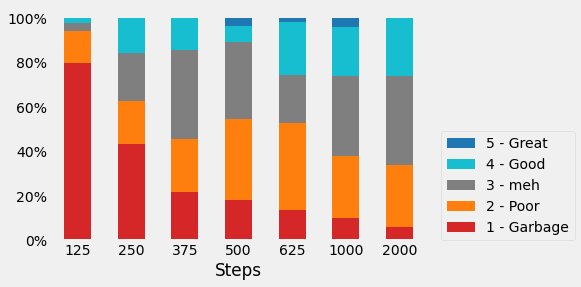

In [67]:
%matplotlib inline
plt.style.use('fivethirtyeight')

rating_per_steps = pd.crosstab(
    fb_df["Steps"], fb_df["Rating_1_to_5"], normalize="index")
color_map_dict = {1: "tab:red", 2: "tab:orange",
                  3: "tab:gray", 4: "tab:cyan", 5: "tab:blue"}
ax = rating_per_steps.plot.bar(stacked=True, color=color_map_dict, fontsize=14)

box = ax.get_position()

handles, labels = ax.get_legend_handles_labels()
ax.legend(handles=handles[::-1], labels=["5 - Great", "4 - Good",
                                         "3 - meh", "2 - Poor", "1 - Garbage"], loc=(1.04, 0), fontsize=14)

plt.xticks(rotation=0)

plt.grid(False)

ax.yaxis.set_major_formatter(mtick.PercentFormatter(1.0))

plt.savefig("rating_per_steps.png", bbox_inches="tight")
plt.show()

In [68]:
# Setting up k-fold cross validation

kf = KFold(10, shuffle=True, random_state=42)

# Defining predictors for models
fb_df["Steps_cent"] = fb_df["Steps"].apply(
    lambda x: x-fb_df["Steps"].mean())  # centering

fb_df["Steps_cent**2"] = fb_df["Steps_cent"]*fb_df["Steps_cent"]
fb_df["Steps_cent**3"] = fb_df["Steps_cent"]**3
fb_df["Steps_cent**4"] = fb_df["Steps_cent"]**4
fb_df["Steps_cent**5"] = fb_df["Steps_cent"]**5

log_model = logreg()

pred_li = [("linear", "Steps_cent"), ("quadratic", "Steps_cent**2"),
           ("cubic", "Steps_cent**3"), ("quartic", "Steps_cent**4"),
           ("quintic", "Steps_cent**5")]

current_preds_col = []

for pred in pred_li:
    current_preds_col.append(pred[1])
    x = fb_df.loc[:, current_preds_col]
    y = fb_df["good_or_better"]
    current_model_name = pred[0]

    cross_val = cross_validate(log_model, x, y,
                               scoring=["neg_log_loss"], cv=kf)
    nll = cross_val["test_neg_log_loss"]
    avg_nll = np.mean(nll)
    print("Model performance for {} model predicting good or better output:".format(
        current_model_name))
    print("negative log loss:{:.4f}\n".format(avg_nll))

# linear model performs best

Model performance for linear model predicting good or better output:
negative log loss:-0.4496

Model performance for quadratic model predicting good or better output:
negative log loss:-0.5176

Model performance for cubic model predicting good or better output:
negative log loss:-0.4950

Model performance for quartic model predicting good or better output:
negative log loss:-0.5450

Model performance for quintic model predicting good or better output:
negative log loss:-0.6240



In [69]:
current_preds_col = []

for pred in pred_li:
    current_preds_col.append(pred[1])
    x = fb_df.loc[:, current_preds_col]
    y = fb_df["poor_or_worse"]
    current_model_name = pred[0]

    cross_val = cross_validate(log_model, x, y,
                               scoring=["neg_log_loss"], cv=kf)
    nll = cross_val["test_neg_log_loss"]
    avg_nll = np.mean(nll)
    print("Model performance for {} model predicting good or better output:".format(
        current_model_name))
    print("negative log loss:{:.4f}\n".format(avg_nll))

# cubic model performs best

Model performance for linear model predicting good or better output:
negative log loss:-0.6627

Model performance for quadratic model predicting good or better output:
negative log loss:-0.6460

Model performance for cubic model predicting good or better output:
negative log loss:-0.6433

Model performance for quartic model predicting good or better output:
negative log loss:-0.6480

Model performance for quintic model predicting good or better output:
negative log loss:-0.6765



In [70]:
log_reg_good = smf.logit("good_or_better ~ Steps_cent", data=fb_df).fit()

print(log_reg_good.summary())

Optimization terminated successfully.
         Current function value: 0.446564
         Iterations 6
                           Logit Regression Results                           
Dep. Variable:         good_or_better   No. Observations:                  362
Model:                          Logit   Df Residuals:                      360
Method:                           MLE   Df Model:                            1
Date:                Tue, 01 Mar 2022   Pseudo R-squ.:                 0.02475
Time:                        23:35:43   Log-Likelihood:                -161.66
converged:                       True   LL-Null:                       -165.76
Covariance Type:            nonrobust   LLR p-value:                  0.004180
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -1.6217      0.145    -11.220      0.000      -1.905      -1.338
Steps_cent     0.0006      0.

In [71]:
log_reg_poor = smf.logit(
    "poor_or_worse ~ Steps_cent + I(Steps_cent**2) + I(Steps_cent**3)", data=fb_df).fit()

print(log_reg_poor.summary())

Optimization terminated successfully.
         Current function value: 0.629059
         Iterations 5
                           Logit Regression Results                           
Dep. Variable:          poor_or_worse   No. Observations:                  362
Model:                          Logit   Df Residuals:                      358
Method:                           MLE   Df Model:                            3
Date:                Tue, 01 Mar 2022   Pseudo R-squ.:                 0.08731
Time:                        23:35:43   Log-Likelihood:                -227.72
converged:                       True   LL-Null:                       -249.50
Covariance Type:            nonrobust   LLR p-value:                 1.865e-09
                         coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------
Intercept             -0.3745      0.170     -2.202      0.028      -0.708      -0.041
Steps

In [72]:
# Dataframe for displaying main effect of TFS only
steps_plot_values = np.arange(100, 2000, 100)

pred_df = pd.DataFrame()

for steps_val in steps_plot_values:
    # The regression used centered values so we need to transform steps_val as well
    steps_val_cent = steps_val - fb_df["Steps"].mean()
    steps_val_cent2 = steps_val_cent**2
    steps_val_cent3 = steps_val_cent**3

    current_pred_dict = (
        {"const": 1, "Steps": steps_val, "Steps_cent": steps_val_cent,
         "Steps_cent2": steps_val_cent2, "Steps_cent3": steps_val_cent3})
    pred_df = pred_df.append(current_pred_dict, ignore_index=True)

# Add predicted values to table constructed above
pred_df["Pred. prob.: Good+"] = log_reg_good.predict(
    pred_df[["const", "Steps_cent"]])
pred_df["Pred. prob.: Poor-"] = log_reg_poor.predict(
    pred_df[["const", "Steps_cent", "Steps_cent2", "Steps_cent3"]])

print(pred_df[["Steps", "Pred. prob.: Good+", "Pred. prob.: Poor-"]].head(10))

    Steps  Pred. prob.: Good+  Pred. prob.: Poor-
0   100.0            0.120151            0.876380
1   200.0            0.126952            0.772831
2   300.0            0.134081            0.656956
3   400.0            0.141544            0.554351
4   500.0            0.149352            0.478365
5   600.0            0.157511            0.430133
6   700.0            0.166028            0.405557
7   800.0            0.174911            0.399811
8   900.0            0.184164            0.408673
9  1000.0            0.193792            0.428380


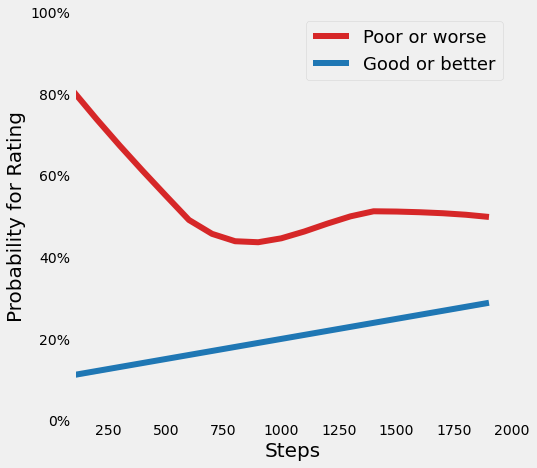

In [73]:
# create the figure and axes
fig, ax = plt.subplots(figsize=(7, 7))

pred_plot = sns.regplot(data=pred_df, y="Pred. prob.: Poor-",
                        x="Steps", lowess=True, scatter=False, ax=ax, label="Poor or worse", color="tab:red")
pred_plot = sns.regplot(data=pred_df, y="Pred. prob.: Good+",
                        x="Steps", lowess=False, scatter=False, ax=ax, label="Good or better", color="tab:blue")


plt.grid(False)
plt.xlim(100, 2000)
plt.ylim(0, 1.0)
plt.ylabel("Probability for Rating")
ax.legend(fontsize=18)
ax.yaxis.set_major_formatter(mtick.PercentFormatter(1.0))

ax.xaxis.label.set_fontsize(20)
ax.yaxis.label.set_fontsize(20)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.savefig("logreg_results.png", bbox_inches="tight")
plt.show()

In [74]:
tokenprobs_dict = {
    "Steps": [125, 250, 375, 500, 625, 1000, 2000],
    "Trolls": [0.07, 0.13, 0.4, 0.7, 1.06, 1.35, 20.96],
    "Humans": [8.13, 6.06, 14.61, 13.75, 16.21, 23.8, 16.32],
    "Elves": [5.05, 9.03, 7.58, 12.42, 7.03, 7.91, 12.32],
    "Gob(lins)": [1.51, 2.61, 0.73, 2.35, 1.62, 4.83, 2.32],
    "Dwar(ves)": [0.86, 2.21, 3.9, 7.42, 10.32, 9.39, 7.71],
    "Undead": [0.28, 0.35, 0.49, 0.75, 1.23, 0.77, 4.52],
    "Og(re)": [0.1, 0.19, 0.16, 0.29, 0.84, 1.19, 3.45],
    "Or(cs)": [0, 0.06, 0.06, 0.08, 0.75, 1.17, 3.45],
    "Half(lings)": [0.08, 0.05, 0.06, 0.08, 0.26, 1.52, 2.71]
}

tokenprobs_df = pd.DataFrame(tokenprobs_dict)
tokenprobs_df

,Steps,Trolls,Humans,Elves,Gob(lins),Dwar(ves),Undead,Og(re),Or(cs),Half(lings)
0,125,0.07,8.13,5.05,1.51,0.86,0.28,0.10,0.00,0.08
1,250,0.13,6.06,9.03,2.61,2.21,0.35,0.19,0.06,0.05
2,375,0.40,14.61,7.58,0.73,3.90,0.49,0.16,0.06,0.06
3,500,0.70,13.75,12.42,2.35,7.42,0.75,0.29,0.08,0.08
4,625,1.06,16.21,7.03,1.62,10.32,1.23,0.84,0.75,0.26
5,1000,1.35,23.80,7.91,4.83,9.39,0.77,1.19,1.17,1.52
6,2000,20.96,16.32,12.32,2.32,7.71,4.52,3.45,3.45,2.71


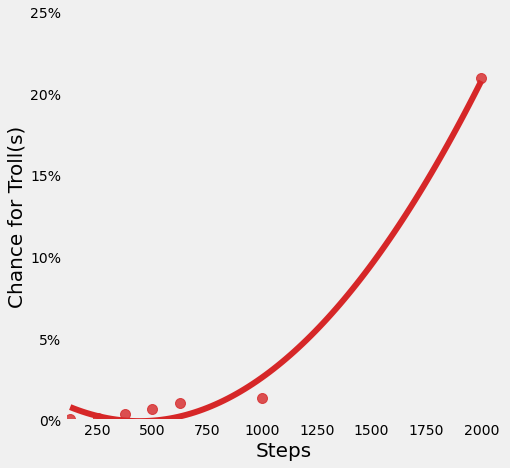

In [75]:
fig, ax = plt.subplots(figsize=(7, 7))
ax.set_xlim(100, 2100)
ax.set_ylim(0, 25)

pred_plot = sns.regplot(data=tokenprobs_df, y="Trolls",
                        x="Steps", order=2, ci=None, scatter=True,
                        ax=ax, label="Troll(s)", color="tab:red",
                        scatter_kws={'s': 100})

plt.grid(False)

plt.ylabel("Chance for Troll(s)")
# ax.legend(fontsize=18)
ax.yaxis.set_major_formatter(mtick.PercentFormatter(decimals=0))

ax.xaxis.label.set_fontsize(20)
ax.yaxis.label.set_fontsize(20)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.savefig("chance_trolls_1.png", bbox_inches="tight")
plt.show()

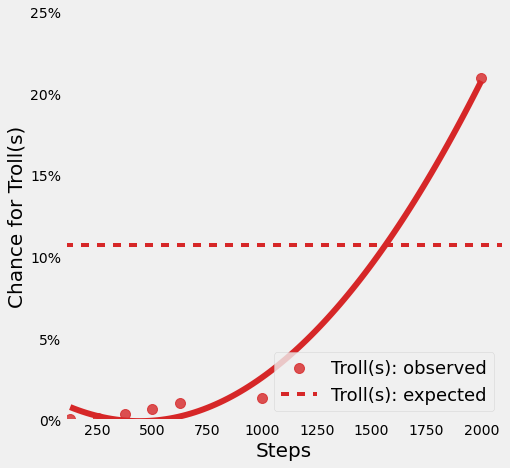

In [76]:
fig, ax = plt.subplots(figsize=(7, 7))
ax.set_xlim(100, 2100)
ax.set_ylim(0, 25)

pred_plot = sns.regplot(data=tokenprobs_df, y="Trolls",
                        x="Steps", order=2, ci=None, scatter=True,
                        ax=ax, label="Troll(s): observed", color="tab:red",
                        scatter_kws={'s': 100})

ax.axhline(y=10.71, dashes = (2,2), color="tab:red", label = "Troll(s): expected")

plt.grid(False)

plt.ylabel("Chance for Troll(s)")
ax.legend(fontsize=18, loc ="lower right")
ax.yaxis.set_major_formatter(mtick.PercentFormatter(decimals=0))

ax.xaxis.label.set_fontsize(20)
ax.yaxis.label.set_fontsize(20)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.savefig("chance_trolls_2.png", bbox_inches="tight")
plt.show()

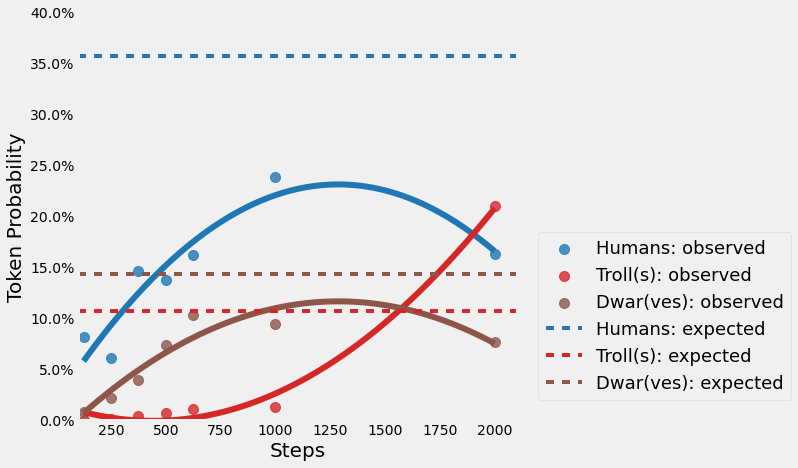

In [77]:
fig, ax = plt.subplots(figsize=(7, 7))
ax.set_xlim(100, 2100)
ax.set_ylim(0, 40)

pred_plot = sns.regplot(data=tokenprobs_df, y="Humans",
                        x="Steps", order=2, scatter=True,
                        ax=ax, label="Humans: observed", color="tab:blue",
                        scatter_kws={'s': 100}, ci = None)

pred_plot = sns.regplot(data=tokenprobs_df, y="Trolls",
                        x="Steps", order=2, scatter=True,
                        ax=ax, label="Troll(s): observed", color="tab:red",
                        scatter_kws={'s': 100}, ci = None)

# pred_plot = sns.regplot(data=tokenprobs_df, y="Elves",
#                         x="Steps", order=2, scatter=True,
#                         ax=ax, label="Elves: observed", color="tab:green",
#                         scatter_kws={'s': 100}, ci = None)

pred_plot = sns.regplot(data=tokenprobs_df, y="Dwar(ves)",
                        x="Steps", order=2, scatter=True,
                        ax=ax, label="Dwar(ves): observed", color="tab:brown",
                        scatter_kws={'s': 100}, ci = None)

ax.axhline(y=35.71, dashes = (2,2), color="tab:blue", label = "Humans: expected")
ax.axhline(y=10.71, dashes = (2,2), color="tab:red", label = "Troll(s): expected")
#ax.axhline(y=14.29, dashes = (2,2), color="tab:green", label = "Elves: expected")
ax.axhline(y=14.29, dashes = (2,2), color="tab:brown", label = "Dwar(ves): expected")

plt.grid(False)

plt.ylabel("Token Probability")
ax.legend(fontsize=18, loc =(1.05,0.05))
ax.yaxis.set_major_formatter(mtick.PercentFormatter())

ax.xaxis.label.set_fontsize(20)
ax.yaxis.label.set_fontsize(20)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.savefig("chance_chars.png", bbox_inches="tight")
plt.show()